In [62]:
from functools import partial

import numpy as np
import pandas as pd
from statsmodels.formula import api as smf

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [70]:
class DataGenerator:
    def __init__(
        self,
        surrogate_distribution: callable,
        non_surrogate_distribution: callable,
        treatment_effect: float = 0.0,
        decay_factor: float = 1.0,
        total_panel: int = 52,
        control_group: bool = True
    ):
        self.surrogate_distribution = surrogate_distribution
        self.non_surrogate_distribution = non_surrogate_distribution
        self.treatment_effect = treatment_effect
        self.decay_factor = decay_factor
        
        self.total_panel = total_panel
        self.is_treatment_group = not control_group

        self.treatment_effects = np.array([treatment_effect*np.exp(-decay_factor*i) for i in range(total_panel)])
    
    def generate_data(self, n_samples:int = 1000, n_surrogates: int = 4):

        surrogate_data = np.clip(self.surrogate_distribution(size=(n_samples, n_surrogates)), a_min=0, a_max=np.inf)
        non_surrogate_data = np.clip(self.non_surrogate_distribution(size=(n_samples, self.total_panel - n_surrogates)), a_min=0, a_max=np.inf)

        full_panel_data = np.hstack([surrogate_data, non_surrogate_data])
        full_panel_data = full_panel_data + self.treatment_effects
        unit_total = full_panel_data.sum(axis=1)
        
        data = (
            pd.DataFrame(
                data = np.hstack([full_panel_data[:, :n_surrogates], unit_total.reshape(-1, 1)]), 
                columns=[f"surrogate_{i}" for i in range(n_surrogates)] + ['unit_total']
            )
            .assign(
                treatment = int(self.is_treatment_group),
            )
        )
        return data

In [73]:
control_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=10, scale=1),
    treatment_effect=5,
    decay_factor=0.1,
    total_panel=52,
    control_group=False
)
control_dg.generate_data(n_samples=10, n_surrogates=4)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,5.000000,4.524187,4.400157,4.978679,542.102880,1
1,6.511834,4.551162,4.093654,3.704091,525.162062,1
2,5.000000,4.524187,4.093654,3.704091,523.399918,1
3,5.000000,5.082098,4.853553,3.704091,539.629541,1
4,5.000000,5.202520,4.093654,3.704091,542.247542,1
5,5.719082,4.524187,4.417541,3.704091,531.769124,1
6,5.000000,4.557862,4.093654,3.704091,538.674627,1
7,5.405429,4.847483,4.093654,3.704091,537.723185,1
8,5.000000,4.524187,4.584342,3.755879,531.534260,1
9,5.482983,4.524187,4.093654,3.704091,530.296064,1


In [74]:
control_dg = DataGenerator(
    surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    non_surrogate_distribution=partial(np.random.normal, loc=0, scale=1),
    treatment_effect=0,
    decay_factor=0.1,
    total_panel=52,
    control_group=True
)
control_dg.generate_data(n_samples=10)

,surrogate_0,surrogate_1,surrogate_2,surrogate_3,unit_total,treatment
0,0.536325,0.000000,1.284251,1.106829,19.225830,0
1,0.419292,1.503379,0.000000,0.000000,24.957310,0
2,0.000000,0.143255,0.632439,0.000000,17.952303,0
3,1.731756,0.420079,1.690180,0.000000,23.509313,0
4,0.000000,0.238381,0.271517,0.000000,28.392300,0
5,0.000000,1.038304,0.691112,0.611146,17.401344,0
6,0.143065,0.000000,0.000000,0.000000,13.854667,0
7,1.672304,0.000000,1.160323,0.538209,24.146159,0
8,0.000000,0.000000,1.431620,0.000000,17.828007,0
9,0.000000,0.472713,0.000000,0.000000,19.343699,0


In [75]:
def generate_train_data(
        n_samples=1000,
        n_surrogates: int = 6, 
        surrogate_dist:callable = partial(np.random.normal, loc=0, scale=1),
        non_surrogate_dist:callable = None
    ) -> pd.DataFrame:
    non_surrogate_dist = non_surrogate_dist or surrogate_dist
    dg = DataGenerator(
        treatment_effect=0.0,
        control_group=False,
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    train_data = dg.generate_data(n_samples=n_samples, n_surrogates=n_surrogates)
    return train_data

def generate_test_data(
        n_samples:int = 1000, 
        treatment_effect:float=0.5, 
        decay_factor:float = 1, 
        n_surrogates: int = 6, 
        surrogate_dist:callable = partial(np.random.normal, loc=0, scale=1),
        non_surrogate_dist:callable = None
    ) -> pd.DataFrame:

    non_surrogate_dist = non_surrogate_dist or surrogate_dist
    dg_c = DataGenerator(
        treatment_effect=0.0, 
        control_group=True, 
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    dg_t = DataGenerator(
        treatment_effect=treatment_effect,
        decay_factor=decay_factor, 
        control_group=False, 
        surrogate_distribution=surrogate_dist,
        non_surrogate_distribution=non_surrogate_dist
    )
    control_data = dg_c.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    treatment_data = dg_t.generate_data(n_samples=n_samples // 2, n_surrogates=n_surrogates)
    test_data = pd.concat([control_data, treatment_data])
    return test_data

def estimate_treatment_effect(data:pd.DataFrame, outcome_col:str, treatment_col:str, return_p_value:bool=False) -> float:
    model = smf.ols(f"{outcome_col} ~ {treatment_col}", data=data)
    result = model.fit()
    if return_p_value:
        return result.params[treatment_col], result.pvalues[treatment_col]
    else:
        return result.params[treatment_col]

def add_sim_fit(train_data:pd.DataFrame, test_data:pd.DataFrame,  outcome_col:str, n_surrogates:int = 6,) -> pd.DataFrame:
    model = smf.ols(f"{outcome_col} ~ {' + '.join([f'surrogate_{i}' for i in range(n_surrogates)])}", data=train_data)
    result = model.fit()
    aug_data = (
        test_data
        .assign(**{
            outcome_col: lambda df: result.predict(df)
        })
    )
    return aug_data

In [38]:
# dist_space = [
#     ('poisson 5', partial(np.random.poisson, lam=5)),
#     ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
#     ('exponential 1', partial(np.random.exponential, scale=1)),
#     ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
# ]

dist_space = [
    ('same as train', None),
    ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
    ('normal 5 1', partial(np.random.normal, loc=5, scale=1)),
    ('normal 10 1', partial(np.random.normal, loc=10, scale=1)),
    ('normal 20 1', partial(np.random.normal, loc=20, scale=1)),
    # ('normal 100 20', partial(np.random.normal, loc=100, scale=20)),
    ('uniform 50 100', partial(np.random.uniform, low=50, high=100)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=0, decay_factor=2, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [39]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,0.131589,0.636986,0.137816,0.148355,-0.006226,same as train
1,0.298257,0.256225,0.060903,0.516643,0.237354,same as train
2,0.167904,0.525994,0.090550,0.301570,0.077354,same as train
3,-0.326221,0.230288,-0.150432,0.093144,-0.175789,same as train
4,0.108187,0.681766,-0.091527,0.321692,0.199714,same as train


Text(0, 0.5, 'Difference in ATE (A/A test)\nobserved vs. prediction data')

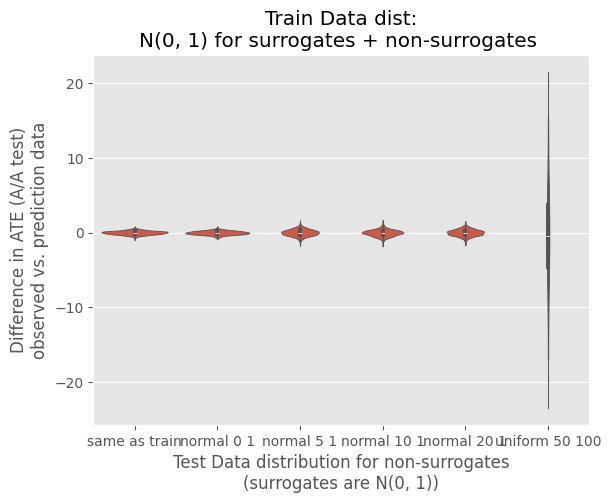

In [40]:
ax = sns.violinplot(
    data = estimate_df,
    x='dist',
    y='diff_estimates'
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates + non-surrogates ')
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))')
ax.set_ylabel('Difference in ATE (A/A test)\nobserved vs. prediction data')

# A/B Test (treatment > 0)

In [81]:
# dist_space = [
#     ('poisson 5', partial(np.random.poisson, lam=5)),
#     ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
#     ('exponential 1', partial(np.random.exponential, scale=1)),
#     ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
# ]

dist_space = [
    ('same as train', None),
    ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
    ('normal 5 1', partial(np.random.normal, loc=5, scale=1)),
    ('normal 10 1', partial(np.random.normal, loc=10, scale=1)),
    ('normal 20 1', partial(np.random.normal, loc=20, scale=1)),
    # ('normal 100 20', partial(np.random.normal, loc=100, scale=20)),
    ('uniform 20 50', partial(np.random.uniform, low=50, high=100)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=1, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [82]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,7.137068,4.230061e-124,8.417341,0.0,-1.280273,same as train
1,7.935052,2.714794e-149,7.724310,0.0,0.210742,same as train
2,8.041147,2.333994e-140,8.047565,0.0,-0.006418,same as train
3,7.802119,1.381759e-130,7.397350,0.0,0.404769,same as train
4,7.752242,1.240611e-133,7.001136,0.0,0.751106,same as train


Text(0, 0.5, 'Difference in ATE (A/B test)\nobserved vs. prediction data')

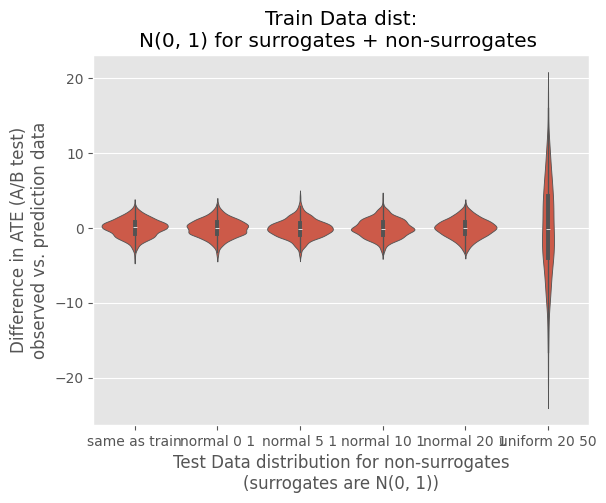

In [83]:
ax = sns.violinplot(
    data = estimate_df,
    x='dist',
    y='diff_estimates'
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates + non-surrogates ')
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))')
ax.set_ylabel('Difference in ATE (A/B test)\nobserved vs. prediction data')

#  Different distributions

In [84]:
# dist_space = [
#     ('poisson 5', partial(np.random.poisson, lam=5)),
#     ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
#     ('exponential 1', partial(np.random.exponential, scale=1)),
#     ('normal 0 1', partial(np.random.normal, loc=0, scale=1)),
# ]

dist_space = [
    ('same as train', None),
    ('poisson 5', partial(np.random.poisson, lam=5)),
    ('multicat', partial(np.random.choice, a=[0, 1, 2], p=[0.75, 0.24, 0.01])),
    ('exponential 1', partial(np.random.exponential, scale=1)),
    ('normal 5 1', partial(np.random.normal, loc=5, scale=1)),
    ('uniform 10 20', partial(np.random.uniform, low=10, high=20)),
]
estimate_df_list = list()
for dist_name, dist in dist_space:
    observed_estimates = list()
    simulated_estimates = list()
    
    for i in range(1000):
        train_data = generate_train_data(n_samples=1000, n_surrogates=6)
        test_data = generate_test_data(n_samples=1000, treatment_effect=5, decay_factor=1, n_surrogates=6, non_surrogate_dist=dist)

        aug_data = add_sim_fit(train_data, test_data, 'unit_total', n_surrogates=6)

        observed_estimates.append(estimate_treatment_effect(test_data, 'unit_total', 'treatment', return_p_value=True))
        simulated_estimates.append(estimate_treatment_effect(aug_data, 'unit_total', 'treatment', return_p_value=True))

    observed_estimate_df = pd.DataFrame(observed_estimates, columns=['estimate', 'p_value'])
    simulated_estimate_df = pd.DataFrame(simulated_estimates, columns=['estimate', 'p_value'])
    full_estimate_df = (
        pd.merge(
            observed_estimate_df,
            simulated_estimate_df,
            left_index=True,
            right_index=True,
            suffixes=('_observed', '_simulated')
        )
        .assign(
            diff_estimates = lambda df: df['estimate_observed'] - df['estimate_simulated']
        )
        .assign(
            dist = dist_name
        )
    )

    estimate_df_list.append(full_estimate_df)

In [85]:
estimate_df = pd.concat(estimate_df_list)
estimate_df.head()

,estimate_observed,p_value_observed,estimate_simulated,p_value_simulated,diff_estimates,dist
0,7.918226,1.426546e-142,6.684218,0.0,1.234008,same as train
1,7.296174,1.836556e-127,9.389840,0.0,-2.093666,same as train
2,8.304170,1.273021e-154,5.998404,0.0,2.305765,same as train
3,8.164057,1.754023e-145,8.404988,0.0,-0.240931,same as train
4,7.667745,1.973251e-135,5.573652,0.0,2.094093,same as train


Text(0, 0.5, 'Difference in ATE (A/B test)\nobserved vs. prediction data')

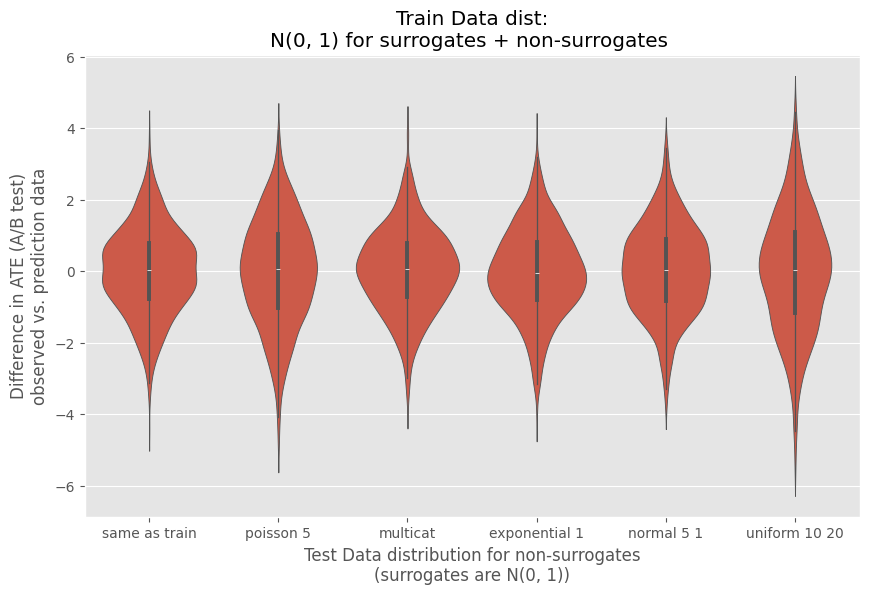

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.violinplot(
    data = estimate_df,
    x='dist',
    y='diff_estimates'
)
ax.set_title('Train Data dist:\nN(0, 1) for surrogates + non-surrogates ')
ax.set_xlabel('Test Data distribution for non-surrogates\n(surrogates are N(0, 1))')
ax.set_ylabel('Difference in ATE (A/B test)\nobserved vs. prediction data')

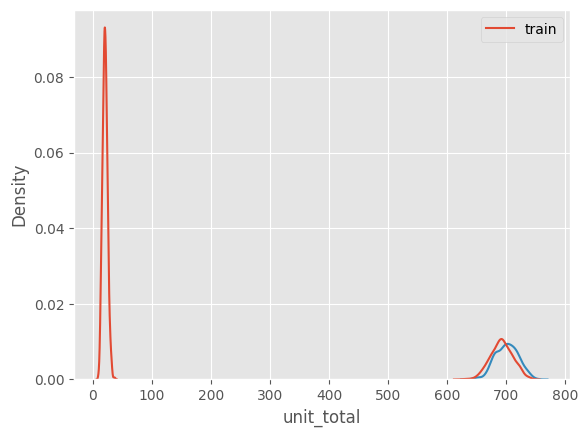

In [87]:
ax = sns.kdeplot(data=train_data, x='unit_total', label='train')
sns.kdeplot(data = test_data, x='unit_total', hue = 'treatment', ax=ax)
ax.legend()

<Axes: xlabel='unit_total', ylabel='Density'>

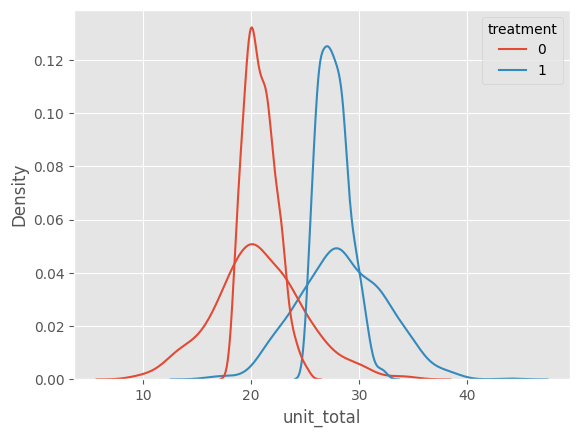

In [ ]:
ax = sns.kdeplot(data=test_data, x='unit_total',  hue = 'treatment')
sns.kdeplot(data = aug_data, x='unit_total', hue = 'treatment', ax=ax)